## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [1]:
import os
import keras

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
## 資料前處理
from keras.utils import to_categorical
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = to_categorical(y, num_classes)
    return y    

In [5]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)
x_train shape: (50000, 3072)
x_test shape: (10000, 3072)
y_train shape: (50000, 10)
y_test shape: (10000, 10)


In [6]:
from keras.layers import Input, Dense
from keras.models import Model

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(input_layer)
        else:
            x = Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(x)
    out = Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
LEARNING_RATE = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.80

In [8]:
from keras import optimizers
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = {:.6f}".format(lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = optimizers.SGD(lr=lr, nesterov=False, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    history = model.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE, 
                        validation_data=(x_test, y_test), 
                        shuffle=True)
    
    # Collect results
    train_loss = history.history["loss"]
    valid_loss = history.history["val_loss"]
    train_acc = history.history["acc"]
    valid_acc = history.history["val_acc"]
    
    exp_name_tag = "exp-lr-{}".format(str(lr))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0325 23:48:16.140446 27124 deprecation_wrapper.py:119] From C:\Users\henry\Anaconda3\envs\finlab\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0325 23:48:16.141446 27124 deprecation_wrapper.py:119] From C:\Users\henry\Anaconda3\envs\finlab\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0325 23:48:16.144447 27124 deprecation_wrapper.py:119] From C:\Users\henry\Anaconda3\envs\finlab\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0325 23:48:16.145447 27124 deprecation_wrapper.py:119] From C:\Users\henry\Anaconda3\envs\finlab\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.pl

Experiment with LR = 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [============================

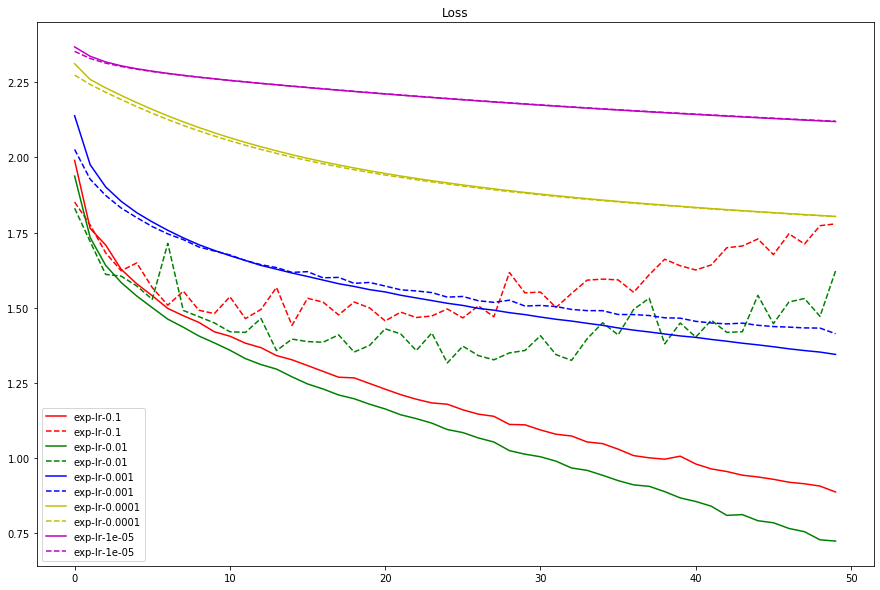

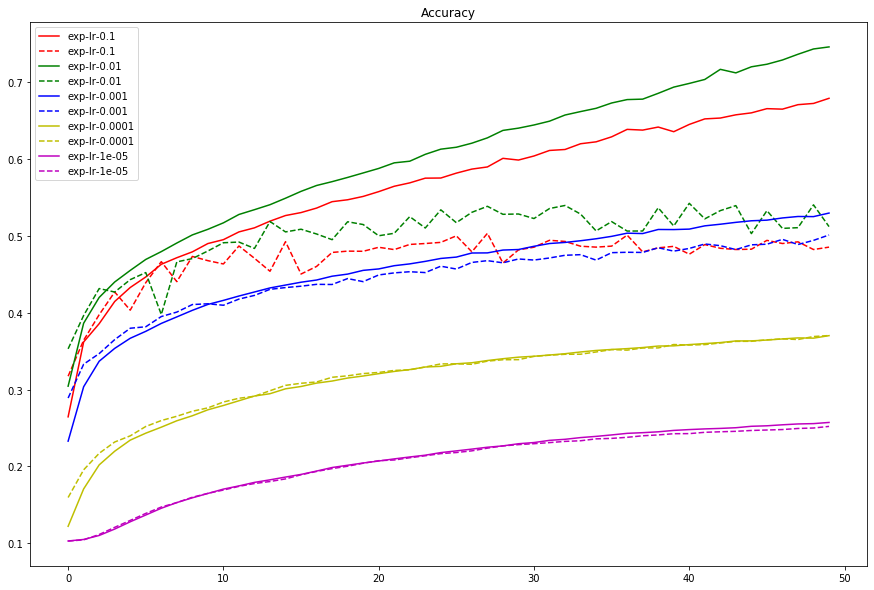

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.rcParams['figure.figsize'] = (15, 10)
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])), results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()

plt.figure()

for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])), results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])), results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()